# Text Analytics for Customer Care

# Seminar goals:
In this project, we will work on Text Analytics applied to Customer Care. These methodologies are broadly used in business to multiple use cases as:
- Identify **leaknesses** in Customer services
- Identify **unsatisfied customers**
- Identify **potential issues** 
- Automate the customer-company interaction

During this project we will follow the end-to-end Machine Learning process: from data gathering and cleaning, exploratory data analysis, feature engineering, model training and prediction, and finally, data visualization in order to identify potential unsatisfied customers, main topics related with a given product, etc.. In particular, the main sections of this project are:
1. Data understanding and preparation: exploration of the dataset and feature engineering
2. Text processing: clean and transform the text in order to improve our model accuracy
2. Model Training: training a Sentimental Analysis Model. Analysis of metrics (recall, precision, confusion metrics)
3. Creating a Business opportunity with Machine Learning: selection of the best model and identification of the most important features
4. Create the Customer Care dashboard: Build up an interactive dashboard in order to convert data into easily consumable information.

**What do you have to deliver?**

- **Code**: This Jupyter completed with your code
- **Visualization**: Some exercises will require an interactive visualization that can be done in any platform (Tableau, Power BI, ...). The only requirement is: if it is not done in Tableau or Power BI you must provide a full guideline about how to install it and any other thing required to use it.
- **Report**: A PDF where you expose your conclusions to those questions remarked with **[REPORT]**


# 0. Context: Using Machine Learning applied to text to improve Customer Care services

We work as a head of data science and AI in a Ecommerce company.

Our Customer Services Department takes a long time to process all the information they have and detect unsatisfied customers. Therefore, they came to us and ask for a platform that solves their problem: automate the data extraction, process the data and deliver the output in a dashboard that they can consume with the objective of being able to detect the unsatisfied customers, the main topics why they are unsatisfied, see the customer's history, and many other graphs that help them to improve the Customer Service.

## 0.1 Dataset

We are working with a kaggle dataset that is composed by two datasets: 

**Product Reviews**

Contains the review done by a customer for a given product. Its fields are the following ones:

- **ReviewTitle**: Title of the review
- **ReviewBody**: Contains the review done by the customer
- **ReviewStar**: How many stars the customer assigns to the product. From 0 to 5, where 0 is the worst value and 5 the best one.
- **Product**: Product identifier

**Product Info**

Contains the info about a given product. Its fields are the following ones:

- **MRP**: Unknown (non used)
- **Price**: price of the product
- **ProductFullName**: Full name of the product
- **ProductShortName**: Short name of the product. This is the one that join the product with all reviews it has.
- **ReviewURL**: URL to see the product description
- **id**: Unique identifier of the product.

## 0.2. Imports

In [12]:
%pip install unidecode

In [13]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import unidecode
import re

# Set Pandas to show all the columns
pd.set_option('display.max_columns', None)

**Download the stemmers**

In [14]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**Continue with the imports**

In [15]:
import nltk.stem as stemmers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input, Dropout, SpatialDropout1D

# **1. Data understanding and preparation**

As you already know, the first stage in any Machine Learning project is to have a clear understanding of the dataset. When working with text this is not as easy as working with numerical data, but after this practice you will know how to proceed. A same sentence can be written in many different ways (for example: how are you? | how are u?), so we must apply different text processing techniques in order to standarize the text and be able to rightly build up models on top of it.

### **1.1 Read the data**

Let's open both csv with separator "," and assign to a dataframe variable (use read_csv from Pandas library). Let's see the top 5 elements.

In [16]:
# Define the parameters to read the data
root_path = "../datos"
info_file = "ProductInfo.csv"
reviews_file = "ProductReviews.csv"
sep = ","
encoding = "utf-8"

# Read the data
info_df = pd.read_csv(filepath_or_buffer=os.path.abspath(os.path.join(root_path, info_file)), sep = sep, encoding = encoding)
reviews_df = pd.read_csv(filepath_or_buffer=os.path.abspath(os.path.join(root_path, reviews_file)), sep = sep, encoding = encoding)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [17]:
info_df

,MRP,Price,ProductFullName,ProductShortName,ReviewURL,id
0,2990,1399,boAt Rockerz 255 Sports Bluetooth Wireless Ear...,boAt Rockerz 255,https://www.amazon.in/255-Bluetooth-Wireless-E...,1
1,3999,1099,Flybot Wave in-Ear Sport Wireless Bluetooth Ea...,Flybot Wave,https://www.amazon.in/Flybot-Wireless-Bluetoot...,2
2,3999,1099,Flybot Boom Deep Bass in-Ear Wireless Bluetoot...,Flybot Boom,https://www.amazon.in/Flybot-Wireless-Bluetoot...,3
3,2000,749,PTron Intunes Pro Headphone Magnetic Earphone ...,PTron Intunes,https://www.amazon.in/PTron-Intunes-Pro-Smartp...,4
4,5999,2999,Flybot Beat True Wireless Bluetooth Earphones ...,Flybot Beat,https://www.amazon.in/Flybot-Wireless-Bluetoot...,5
5,3799,3190,Samsung EO-BG950CBEGIN Bluetooth Wireless in-E...,Samsung EO-BG950CBEIN,https://www.amazon.in/Samsung-EO-BG950CBEGIN-B...,6
6,2999,1999,JBL T205BT Pure Bass Wireless Metal Earbud Hea...,JBL T205BT,https://www.amazon.in/JBL-T205BT-Wireless-Earb...,7
7,7490,6499,Sennheiser CX 6.0BT 507447 in Ear Wireless Ear...,Sennheiser CX 6.0BT,https://www.amazon.in/Sennheiser-CX-507447-Wir...,8
8,5299,3699,Skullcandy S2PGHW-174 in-Ear Wireless Headphon...,Skullcandy S2PGHW-174,https://www.amazon.in/Skullcandy-S2PGHW-174-Wi...,9
9,2259,2000,JBL T110BT Pure Bass Wireless in-Ear Headphone...,JBL T110BT,https://www.amazon.in/JBL-T110BT-Wireless-Head...,10


In [18]:
reviews_df

,ReviewTitle,ReviewBody,ReviewStar,Product
0,Honest review of an edm music lover\n,No doubt it has a great bass and to a great ex...,3,boAt Rockerz 255
1,Unreliable earphones with high cost\n,"This earphones are unreliable, i bought it be...",1,boAt Rockerz 255
2,Really good and durable.\n,"i bought itfor 999,I purchased it second time,...",4,boAt Rockerz 255
3,stopped working in just 14 days\n,Its sound quality is adorable. overall it was ...,1,boAt Rockerz 255
4,Just Awesome Wireless Headphone under 1000...😉\n,Its Awesome... Good sound quality & 8-9 hrs ba...,5,boAt Rockerz 255
...,...,...,...,...
14332,Good\n,Good\n,4,JBL T110BT
14333,Amazing Product\n,An amazing product but a bit costly.\n,5,JBL T110BT
14334,Not bad\n,Sound\n,1,JBL T110BT
14335,a good product\n,the sound is good battery life is good but the...,5,JBL T110BT


[**EX 1**] 

Keep and rename the defined fields per dataframe and join them. The resulted dataframe must be named as _data_. Moreover, assing an incremental ID (called as _id_) to each review in order to be able to identify it in future steps

- **info_df**: 
    - ProductShortName: Product
    - Price: Price
    
    
- **reviews_df**: 
    - ReviewBody: Text 
    - ReviewStar: Star
    - Product: Product

**Solution**

In [19]:
info_df = info_df[['ProductShortName', 'Price']] #filter 
info_df.rename(columns={"ProductShortName": "Product"}, inplace=True) #rename variables

reviews_df = reviews_df[['ReviewBody', 'ReviewStar', 'Product']] #filter
reviews_df.rename(columns={"ReviewBody": "Text", "ReviewStar": "Star"}, inplace=True) #rename variables

#merge both df
data = pd.merge(info_df, reviews_df, on="Product")
data['id'] = data.index #add an id column
data.head(5)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Product,Price,Text,Star,id
0,boAt Rockerz 255,1399,No doubt it has a great bass and to a great ex...,3,0
1,boAt Rockerz 255,1399,"This earphones are unreliable, i bought it be...",1,1
2,boAt Rockerz 255,1399,"i bought itfor 999,I purchased it second time,...",4,2
3,boAt Rockerz 255,1399,Its sound quality is adorable. overall it was ...,1,3
4,boAt Rockerz 255,1399,Its Awesome... Good sound quality & 8-9 hrs ba...,5,4


**Split the dataset into data to be used during the class and data to be used during report generation**

In [20]:
# Keep the 10% for reporting
data_report = data.sample(frac = 0.1)

# The rest for class
data = data.drop(index=data_report.index)

### **1.2 Dataset Exploratory Data Analysis (EDA)**

Working with text is more complex than with numerical data, so EDA must be done in a different way. The reason behind is the ramdon component when writing/typing, where a given sentence can be written in many different ways. Therefore, the EDA must be done twice: Firstly, no standardizing the text in order to define the cleaning processes we have to apply, and sencodly when text is standardized and we can extract real information from it. 

### **1.2.1 Defining cleaning process**

The first thing we must do is to have a look at the text and check if there is anything that catches your eye. 

[**EX1**]

Identify the type of each variable and check if they are rightly assigned. In case no, then change it to:

- Text: string (object in Pandas)
- Star: int
- Product: string (object in Pandas)
- Price: int

**Questions**

- How many records does the data have?

- How many nulls does each attribute have? Have a look at the text and check if there is no masked null values.

**Solution**

Aparently there is no nulls in any field, but in Text this assumption is fake. There are some records with only '\n' values or emojis, so we must clean it before answering this question

In [21]:
data.info()
print('The data types are correctly assigned.')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12903 entries, 0 to 14336
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Product  12903 non-null  object
 1   Price    12903 non-null  int64 
 2   Text     12903 non-null  object
 3   Star     12903 non-null  int64 
 4   id       12903 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 604.8+ KB
The data types are correctly assigned.


In [22]:
print('There are no null values in any of the variables.')
data.isna().sum()

There are no null values in any of the variables.


Product    0
Price      0
Text       0
Star       0
id         0
dtype: int64

In [23]:
print('But if we sort the \'Text\' values, we observe some masked null values like \'\\n\' and emojis, which provide no value at all.')
data['Text'].sort_values()

But if we sort the 'Text' values, we observe some masked null values like '\n' and emojis, which provide no value at all.


14263                                                   \n
5742                                                    \n
11946                     "material quality" is not good\n
73       # Light but well built, doesn't feel bulky# Ba...
45       ** the product was a perfect purchase... but i...
                               ...                        
4152                                    😍😍😍best in class\n
3675                                                  😘💪\n
3546                                                 🙏🙏🙏\n
4221     🤗🤗happy and satisfied to buy this Bluetooth ea...
4605                                                  🤟🏻\n
Name: Text, Length: 12903, dtype: object

--------
As mentioned above, working with text is not as direct as we thought. Text can contain some strange values like emojis or whitespace characters (\s, \n, \t, \r) that must be removed from text. 

[**EX 2**] 

Inspect the Text values and check if there is emojis or any other strange character that must be removed. Explain what you have found.

**Solution**

In [24]:
print('We can see some different emojis and some characters that need to be removed. For example: #, *, \",\\n')
data['Text'].sort_values()

We can see some different emojis and some characters that need to be removed. For example: #, *, ",\n


14263                                                   \n
5742                                                    \n
11946                     "material quality" is not good\n
73       # Light but well built, doesn't feel bulky# Ba...
45       ** the product was a perfect purchase... but i...
                               ...                        
4152                                    😍😍😍best in class\n
3675                                                  😘💪\n
3546                                                 🙏🙏🙏\n
4221     🤗🤗happy and satisfied to buy this Bluetooth ea...
4605                                                  🤟🏻\n
Name: Text, Length: 12903, dtype: object

**[EX 3]** 

Fill up the following functions where is marked with TODO. In case you need/want to add new functions, just add them in the same cell than the others. Demostrate your process has been properly done by inspecting some Text and Text_Clean values.

**Solution**

In [25]:
import unidecode

def remove_accents(text):
    if text:
        return unidecode.unidecode(text) # TODO: remove the accents from text (tip: search for unicode)
        

    # In case there is no text
    return ""

def remove_punctuation_marks(text):
    if text:
        return text.translate(str.maketrans(dict.fromkeys(string.punctuation))) # TODO: Remove the punctuation marks from text (tip: search for translate and maketrans)

    # In case there is no text
    return ""

def text_to_lower_case(text):
    if text:
        return text.lower()# TODO: convert text to lower case
        
    # In case there is no text
    return ""

def remove_emojis(text):
    if text:
        return text.encode('ascii', 'ignore').decode('ascii') # TODO: Remove emojis (tip: search for encode - decode)

    # In case there is no text
    return ""

def remove_multiple_whitespaces(text):
    if text:
        return re.sub(' +', ' ', text)# TODO: remove multiple whitespaces (tip: search for regex and replace)
    
    # In case there is no text
    return ""

def remove_text_marks(text):
    if text:
        text = re.sub(r'\'', '', text)# TODO: replace characters like it\'s by its
        
        text = re.sub(r"[-()\"#/@;:<>{}=~|.?,]", "", text)# TODO: replace *, ?, ... by spaces
        
        return text.strip()
    
    # In case there is no text
    return ""

def split_text_and_numbers(text):
    return text

def remove_alone_numbers(text):
    if text:
        return re.sub(r'\d', '', text)# TODO: keep only text
        
        #return text
    
    return ""

def clean_text(text):
    # Apply the different functions in order to clean the text
    text = text_to_lower_case(text)
    text = remove_text_marks(text)
    text = remove_punctuation_marks(text)
    text = remove_accents(text)
    text = remove_emojis(text)
    text = split_text_and_numbers(text)
    text = remove_alone_numbers(text)
    text = remove_multiple_whitespaces(text)
    
    # Return
    return text

In [26]:
data['Text_Clean'] = data.Text.apply(lambda text: clean_text(text))

In [27]:
data[["Text", "Text_Clean"]].tail(1).values

array([['M writing this review after using for almost 7 months , now it has stopped working n have mailed my concern to JBL as it had 1 year of warranty but believe me nobody is ready to reslove or respond to my query, wastey my money on this just because of brand value totally disappointed\n',
        'm writing this review after using for almost months now it has stopped working n have mailed my concern to jbl as it had year of warranty but believe me nobody is ready to reslove or respond to my query wastey my money on this just because of brand value totally disappointed']],
      dtype=object)

### **1.2.2 EDA in text**

- **Book**: [Natural Language Processing with Python](https://www.nltk.org/book/)

Once text is cleaned we can apply the EDA to it. To this step I highly recommend you to use the book indicated above, which will provides you a great guideline about how to work with text.

#### **1.2.2.1 Converting to nltk.Text** 

In order to be able to take the most of NLTK power, we must firstly convert the text into [nltk.Text](https://www.kite.com/python/docs/nltk.Text) objects. In order to do this, nltk needs to receive a list of tokens (smallest piece of text -- a word).

**[EX 4]** 

Fill up the function *convert_to_nltk_text* where is marked with TODO.

**Solution**

In [28]:
def convert_to_nltk_text(data, 
                         text_field):
    # List that will store tokens
    tokens = []
    
    # TODO: Fill up the tokens list with the text comming from data[text_field] 
    for i in data[text_field].values:
          tokens.extend(i.split(" "))
    
    # Return nltk.Text object
    return nltk.Text(tokens)

In [29]:
# Get the nltk.Text object
nltk_text = convert_to_nltk_text(data, "Text_Clean")

The nltk.Text object is mainly composed by tokens. If you want to see them you can just type nltk_text.tokens and have a look.

In [30]:
nltk_text.tokens[:20]  # Show only 20. Increase it if you want to

['no',
 'doubt',
 'it',
 'has',
 'a',
 'great',
 'bass',
 'and',
 'to',
 'a',
 'great',
 'extent',
 'noise',
 'cancellation',
 'and',
 'decent',
 'sound',
 'clarity',
 'and',
 'mindblowing']

#### **1.2.2.2 Frequency distributions** 

Tells us the frequency of each vocabulary item in the text. This is very important when working with text because it tells you the main words of a given set of texts; really usefull when trying to detect the main topics why customers are unsatisfied.

In [31]:
# Get the dictionary with frequencies
freq_dist = nltk.FreqDist(nltk_text)

# Shows 50 first words in frequency 
list(freq_dist.keys())[:50]

['no',
 'doubt',
 'it',
 'has',
 'a',
 'great',
 'bass',
 'and',
 'to',
 'extent',
 'noise',
 'cancellation',
 'decent',
 'sound',
 'clarity',
 'mindblowing',
 'battery',
 'but',
 'the',
 'following',
 'dissapointed',
 'me',
 'though',
 'i',
 'tried',
 'lot',
 'adjustbluetooth',
 'range',
 'not',
 'more',
 'than',
 'm',
 'pain',
 'in',
 'ear',
 'due',
 'conical',
 'budscan',
 'be',
 'removed',
 'wires',
 'are',
 'bit',
 'long',
 'which',
 'makes',
 'odd',
 'front',
 'pouch',
 'provided']

Moreover, the FreqDist object allows you to plot the distribution as well, in terms of cumulative and no cumulative counts

- **No cumulative**: Determines the number of times a word appears on text

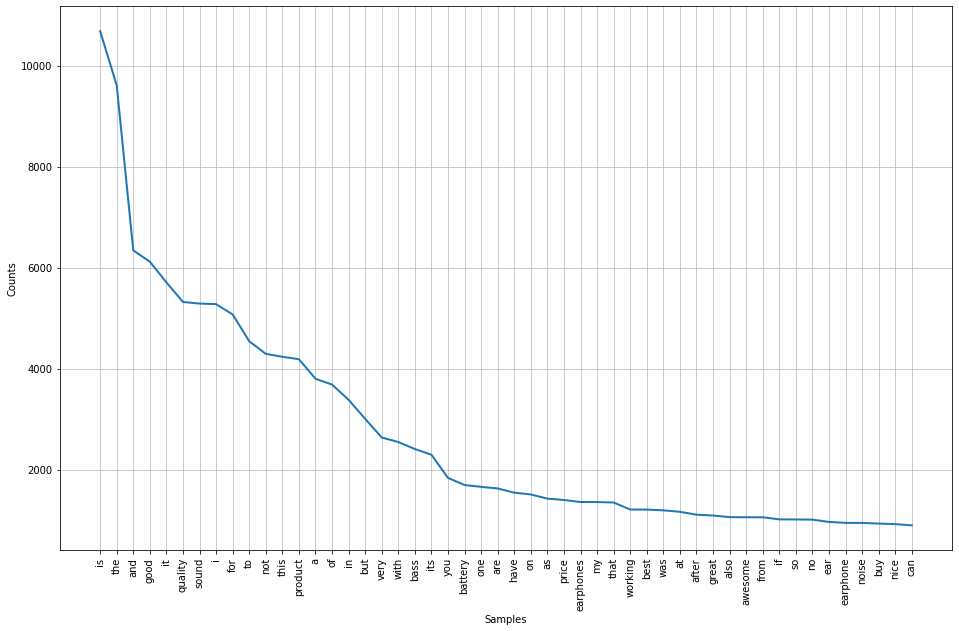

In [32]:
plt.figure(figsize = (16, 10))
freq_dist.plot(50)

- **Cumulative**: Determine the proportion that represents these words within the whole text. 

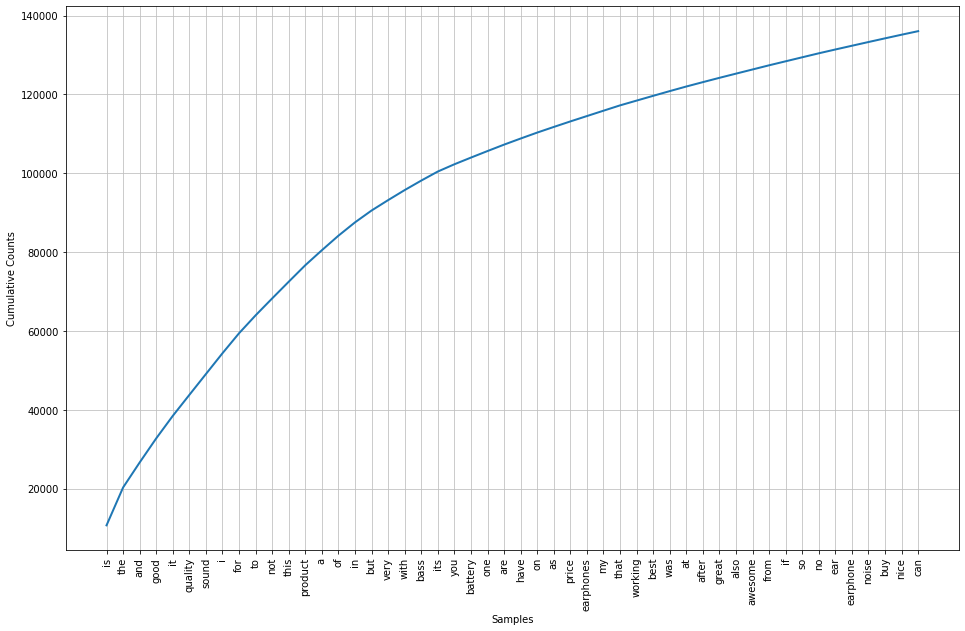

In [33]:
plt.figure(figsize = (16, 10))
freq_dist.plot(50, cumulative = True)

**[EX 5]**

From the information shown above (plots and list), what do you appreciate? Are the most important words meaningful words? Explain your comments bellow

**Solution**

In [34]:
print('From the information shown above, we appreciate that the most important words are stop words that have not any meaning by themselves (determinants, conjunctions, ...) . ')

From the information shown above, we appreciate that the most important words are stop words that have not any meaning by themselves (determinants, conjunctions, ...) . 


There are many stop words (meaningless words -- determinants, pronouns, ...) that must be removed. Moreover, there are not that much amount of verbs, but those we have are in different forms (be -> is, are, was ...)

#### **1.2.2.3 Standardizing the text**

Once the EDA is performed, the following step is to standardize the text. This step is done by removing the stop words (meaningless words, such us determinants and pronouns) and lemmatizing.

**Lemmatizing**

*Lemmatizing text* means to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma. For example, imagine the same sentence as before. Therefore, after lemmatizing the sentence we would get *[my, dog, be, white, yours, black]*

**Stop words**

*Stop words* are those words that does not have any meaning for us when processing text, such as *the, a, of ...*. They must be removed from the text/tokens list. 

[**EX 6**] 

Fill up the following functions (where it is marked with TODO) in order to build up a function that standardize the text. You will notice that there is a function that returns the tokens for a given text. The reason behind is that now, at this moment, I want you to use nltk.Text objects to be able to plot different graphics and explore the EDA using NLTK. But after you have learnt and check the EDA you did, the next step is to be able to do the same but using the text you have in your Pandas DataFrame.

**Solution**

In [35]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [36]:
def get_tokens(text):
    # Get the tokens
    if isinstance(text, nltk.Text):
        tokens = text.tokens
    else:
        tokens = text.split(" ")
        
    return tokens

def remove_stopwords(text, language):
    # Import stopwords
    from nltk.corpus import stopwords
    
    # Get stop words for the given language
    stopwords_list = stopwords.words(language)
    
    # Get the tokens
    tokens = get_tokens(text)
        
    # TODO: Remove the words from the text (tip: check the nltk.Text object and stopwords in NLTK)
    cleaned_text = []
    for word in tokens:
        if word not in stopwords_list:
            cleaned_text.append(word)
    
    # Return cleaned text
    if isinstance(text, nltk.Text):
        output = nltk.Text(cleaned_text)
    else:
        output = " ".join(cleaned_text)
    
    return output

def stem_text(text,
              language):
    # TODO: Create the stemmer (tip: see the class nltk.stem)
    stemmer = stemmers.SnowballStemmer(language)
    
    # Get the tokens
    tokens = get_tokens(text)
    
    # TODO: Stem each token in text object
    stemmas = []
    for word in tokens: 
        stemmas.append(stemmer.stem(word))
    
    # Return stemmed text
    if isinstance(text, nltk.Text):
        output = nltk.Text(stemmas)
    else:
        output = " ".join(stemmas)
    
    return output

def standardize_text(text,
                     language):
    # Remove the stop words
    standardized_text = remove_stopwords(text, language)
    
    # Stem the text
    standardized_text = stem_text(standardized_text, language)
    
    # Return
    return standardized_text

Apply the standardization over the nltk.Text and pd.DataFrame objects

In [37]:
standardized_nltk_text = standardize_text(nltk_text, "english")
data['Standardized_Text'] = data.Text_Clean.apply(lambda text: standardize_text(text, "english"))

In [38]:
data.head()

,Product,Price,Text,Star,id,Text_Clean,Standardized_Text
0,boAt Rockerz 255,1399,No doubt it has a great bass and to a great ex...,3,0,no doubt it has a great bass and to a great ex...,doubt great bass great extent nois cancel dece...
1,boAt Rockerz 255,1399,"This earphones are unreliable, i bought it be...",1,1,this earphones are unreliable i bought it befo...,earphon unreli bought day meanwhil right side ...
2,boAt Rockerz 255,1399,"i bought itfor 999,I purchased it second time,...",4,2,i bought itfor i purchased it second time gift...,bought itfor purchas second time gift first on...
3,boAt Rockerz 255,1399,Its sound quality is adorable. overall it was ...,1,3,its sound quality is adorable overall it was g...,sound qualiti ador overal good week stop work ...
4,boAt Rockerz 255,1399,Its Awesome... Good sound quality & 8-9 hrs ba...,5,4,its awesome good sound quality hrs battery lif...,awesom good sound qualiti hrs batteri life waw...


**[EX 7]**

Plot the frequency distribution for the standardized text and explain the differences you appreciate between this one and the one you did with the *dirty* text

**Solution**

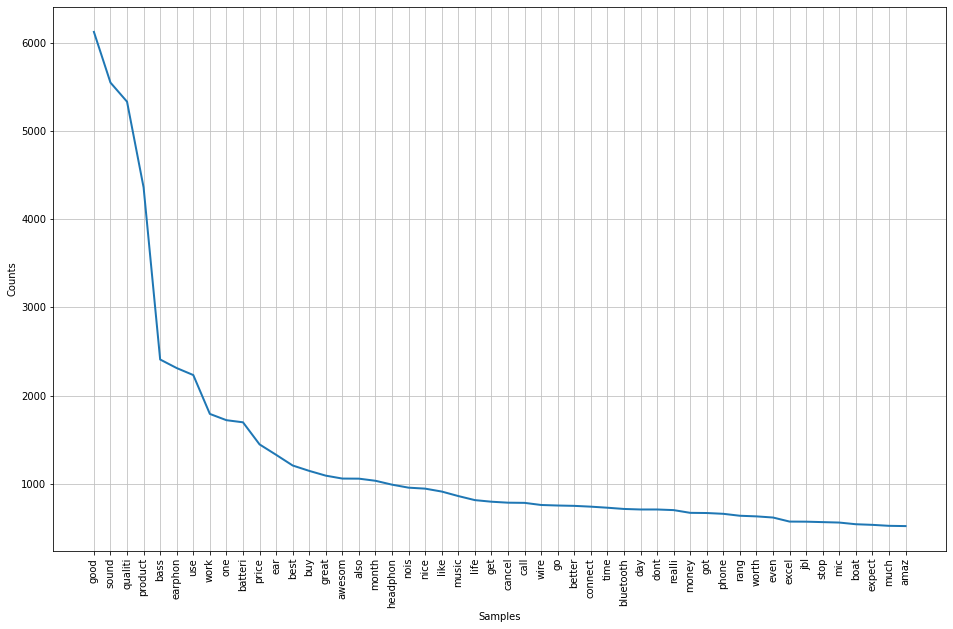

In [39]:
plt.figure(figsize = (16, 10))
nltk.FreqDist(standardized_nltk_text).plot(50)

We can appreciate that there are no meaningless words, and the ones we kept are the ones that indicates why people is satisfied/unsatisfied with the product

#### **1.2.2.4 Extracting the most important words and their context**

One really powerfull tool when analizing text is to extract which are the most important words (main topics), due to this information will let us to know what our customer, mainly, thinks about our products. In case our product is good and customers like it, then the hypothesis is that the main words that they will use are positive words (good, fine, awesome, like ...). And in the opposite case, if customers are unsatisfied with the product, the main words should be negative words (awful, bad, ...).

However, the main word itself does not provide a full description of what it happening. Therefore, you will need to describe the context in which the main word was used for. The words that describe the context of a given main words are called _related words_

The way in which this is done using NLTK is by means of the Frequency Distribution object. This object provides an access to a Python tuple by its parameter *most_common*, which is composed by (word, word count)

For example, if you want to know the top-50 most common words you should do the following 

In [40]:
nltk.FreqDist(standardized_nltk_text).most_common(50)

[('good', 6120),
 ('sound', 5546),
 ('qualiti', 5330),
 ('product', 4359),
 ('bass', 2411),
 ('earphon', 2314),
 ('use', 2235),
 ('work', 1795),
 ('one', 1724),
 ('batteri', 1700),
 ('price', 1450),
 ('ear', 1332),
 ('best', 1211),
 ('buy', 1150),
 ('great', 1096),
 ('awesom', 1063),
 ('also', 1062),
 ('month', 1038),
 ('headphon', 994),
 ('nois', 960),
 ('nice', 949),
 ('like', 916),
 ('music', 865),
 ('life', 819),
 ('get', 801),
 ('cancel', 790),
 ('call', 788),
 ('wire', 764),
 ('go', 758),
 ('better', 754),
 ('connect', 745),
 ('time', 733),
 ('bluetooth', 719),
 ('day', 713),
 ('dont', 713),
 ('realli', 706),
 ('money', 675),
 ('got', 673),
 ('phone', 664),
 ('rang', 642),
 ('worth', 635),
 ('even', 622),
 ('excel', 576),
 ('jbl', 575),
 ('stop', 570),
 ('mic', 565),
 ('boat', 546),
 ('expect', 539),
 ('much', 528),
 ('amaz', 525)]

Regarding to the context, NLTK provides a function called *concordance* that shows every occurence of a given word, together with some context. So, for example, if you want to know the context in which *good* was used, then you should the following

In [41]:
standardized_nltk_text.concordance("good")

Displaying 25 of 6120 matches:
vid two part sound qualiti also much good ok one thing bass good boat earphone
iti also much good ok one thing bass good boat earphonesguysalso proof attach 
t call switch mobilethi switch devic good price awesomebatteri stand hour use 
omfort ear sound qualiti ador overal good week stop work sinc never power clai
 claim warrenti still undergo awesom good sound qualiti hrs batteri life waww 
 qualitybatteri life earphon qualiti good strong magnet lock strap good qualit
ualiti good strong magnet lock strap good qualiti earphon wire good button qua
lock strap good qualiti earphon wire good button qualiti good sound full punch
iti earphon wire good button qualiti good sound full punchi bass balanc trebl 
chi bass balanc trebl sorrund effect good fit ear hope connect good bcz last b
und effect good fit ear hope connect good bcz last boat bluetooth basshead con
connect issu worth price hope packag good bubbl wrap one month usag review pro
maz perfect music lov

But, as you could appreciate, this function only print information, so it is only used to display, not to process and get results. And, moreover, it is not readable/understandable which is the real context if we use the standardized text. In order to know it, this step must be performed over the original text, because after processing we know which is the most common word but at the same time we have removed information from text.

In [42]:
nltk_text.concordance("good")

Displaying 25 of 6118 matches:
 sound quality is also not that much good but ok one more thing bass is not go
od but ok one more thing bass is not good as it is a boat earphonesguysalso fo
ilethis switch between device is not good but again in this price its awesomeb
d quality is adorable overall it was good but just for weeks after that it sto
d it is still undergoing its awesome good sound quality hrs battery life just 
itybattery life earphones quality is good with strong magnetic lock straps is 
 with strong magnetic lock straps is good quality and the earphones wires are 
lity and the earphones wires are too good buttons quality is good sound is ful
ires are too good buttons quality is good sound is full of punchy bass and and
lanced treble and has sorrund effect good fitting in ears hope connectivity is
fitting in ears hope connectivity is good bcz my last boat bluetooth bassheads
rth its price hope the packaging was good there was no bubble wrapping after o
or a music lover the 

### **1.2.3 Relating stars with sentiment**

So far you have gotten a good understanding about what's going on with the text. In order to build up the sentimental analysis model, we need to transform *star* numbers into sentiments. To do this, we will match them as follows:

- **Bad sentiment**: stars 1 and 2 --> bad
- **Intermediate sentiment**: star 3 --> neutral
- **Good sentiment**: stars 4 and 5 --> good

[**EX 8**]

Do the star-sentiment matching as explained above. Set this value into a new field named *Sentiment* and remove the *Star* field

**Solution**

In [43]:
def star_sentiment_matching(value):
    if value <= 2: 
        return 'bad'
    elif value == 3: 
        return 'neutral'
    else: 
        return 'good'   

In [44]:
# Match the sentiment value
data['Sentiment'] = data.Star.apply(lambda value: star_sentiment_matching(value))

# Remove the star field
data = data.drop(columns = ["Star"])
data.head()

,Product,Price,Text,id,Text_Clean,Standardized_Text,Sentiment
0,boAt Rockerz 255,1399,No doubt it has a great bass and to a great ex...,0,no doubt it has a great bass and to a great ex...,doubt great bass great extent nois cancel dece...,neutral
1,boAt Rockerz 255,1399,"This earphones are unreliable, i bought it be...",1,this earphones are unreliable i bought it befo...,earphon unreli bought day meanwhil right side ...,bad
2,boAt Rockerz 255,1399,"i bought itfor 999,I purchased it second time,...",2,i bought itfor i purchased it second time gift...,bought itfor purchas second time gift first on...,good
3,boAt Rockerz 255,1399,Its sound quality is adorable. overall it was ...,3,its sound quality is adorable overall it was g...,sound qualiti ador overal good week stop work ...,bad
4,boAt Rockerz 255,1399,Its Awesome... Good sound quality & 8-9 hrs ba...,4,its awesome good sound quality hrs battery lif...,awesom good sound qualiti hrs batteri life waw...,good


**[EX 9]**

Plot the number of comments per sentiment and determine if the dataset is balanced or not

**Solution**

AS we can observe, the dataset is unbalanced. There is much more good feedback, than both bad and neutral combined.


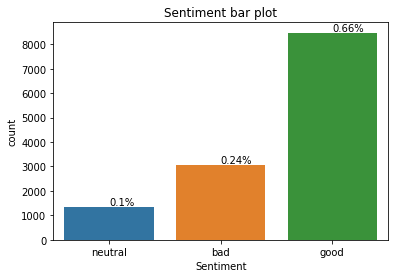

In [45]:
from collections import Counter
sentiment_counter = Counter(data['Sentiment'])

print("AS we can observe, the dataset is unbalanced. There is much more good feedback, than both bad and neutral combined.")

ax = sns.countplot(x="Sentiment", data=data)
plt.title('Sentiment bar plot')
ratio_bad = round(sentiment_counter['bad']/(sentiment_counter['bad'] + sentiment_counter['neutral']+sentiment_counter['good']), 2) 
ratio_neutral = round(sentiment_counter['neutral']/(sentiment_counter['bad'] + sentiment_counter['neutral']+sentiment_counter['good']), 2)
ratio_good = round(sentiment_counter['good']/(sentiment_counter['bad'] + sentiment_counter['neutral']+sentiment_counter['good']), 2)
plt.text(1, sentiment_counter['bad'] + 50, str(ratio_bad) + '%')
plt.text(0, sentiment_counter['neutral'] + 50, str(ratio_neutral) + '%')
plt.text(2, sentiment_counter['good'] + 50, str(ratio_good) + '%')
plt.show()

# **2. Model Training: Building a sentimental analysis model**

Once the EDA is done, you are ready to build up the sentimental analysis model. The objective of this model is to be able to predict if a given customer is disgusted with our product, and in that case, be able to track its evolution and apply any business rule in order to avoid the churner ratio to increase.

The model we are going to develop is based on [LSTMs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/). It will take as input a given text and outputs the sentiment related to it. 

### 2.1. Balancing the dataset 

**[EX 10]** 

Fill up the function *balance_dataset* (where is marked as TODO) in order to balance (or not) the dataset by keeping the same amount of data per class. The input parameters are:

- dataset: dataset to be balanced
- balance: flag that determines if the dataset must be balanced or not.
- replace: flag that determines if random samples must be replaced when balancing

**Solution**

In [46]:
def balance_dataset(dataset: pd.DataFrame,
                    sample_number: int,
                    balance: bool = False,
                    replace: bool = False):
    
    # TODO: implement the balancing process
    if balance:
        return dataset.groupby("Sentiment", as_index=False).apply(lambda x: x.sample(n=sample_number, replace=replace))

    return dataset
    

Balance the dataset

In [47]:
# Define the parameters
sample_number = 3000
balance = True
replace = True

# And balance
training = balance_dataset(dataset = data,
                           sample_number = sample_number,
                           balance = balance,
                           replace = replace)

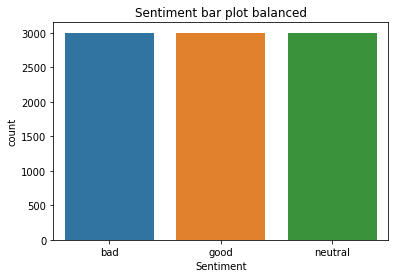

Now the dataset is balanced.


In [48]:
ax = sns.countplot(x="Sentiment", data=training)
plt.title('Sentiment bar plot balanced')
plt.show()
print("Now the dataset is balanced.")

### 2.2. Converting text into numeric values

When working with LSTMs (and almost with any other model) the input must be numerical. Therefore, we need to map our text into numerical values, and for this purpose we will tokenize the text and pad it.

In [49]:
# Define the text field to be used
text_field = "Standardized_Text"

There is a very important question here, and it is: how many words do I keep? In order to be able to answer this question, we will plot the distribution and box plot of the text length.

**[EX 11]**

Fill up the function *plot_text_length_distribution* (where is marked as TODO). This function will plot the distribution and box plot of the text length and define the vocabulary (future value of *max_num_words*) of the text.

**Solution**

In [50]:
def plot_text_length_distribution(dataset: pd.DataFrame,
                                  text_field: str):
    # TODO: compute the vocabulary size for the given text field
    vocabulary_size = len(np.unique(dataset[text_field].values))
    print("\nThe vocabulary is composed by {0} words \n".format(vocabulary_size))
    
    # TODO: compute the lengths
    lengths = dataset[text_field].str.split(" ").apply(len).value_counts()
    
    # Build the figures
    plt.figure(figsize = (16, 10))
    plt.subplot(211)
    
    # TODO: Plot the distribution
    plt.bar(x=lengths.keys(), height=lengths.values)
    
    # Assign the title
    plt.title("Distribución de la longitud de las frases")
    plt.xlabel("Longitud de la frase")
    plt.ylabel("Número de frases")

    # Set the second plot
    plt.subplot(212)
    
    # TODO: plot the box plot
    plt.boxplot(x=lengths.keys())
    
    # Show
    plt.show()

Plot the distribution


The vocabulary is composed by 5160 words 



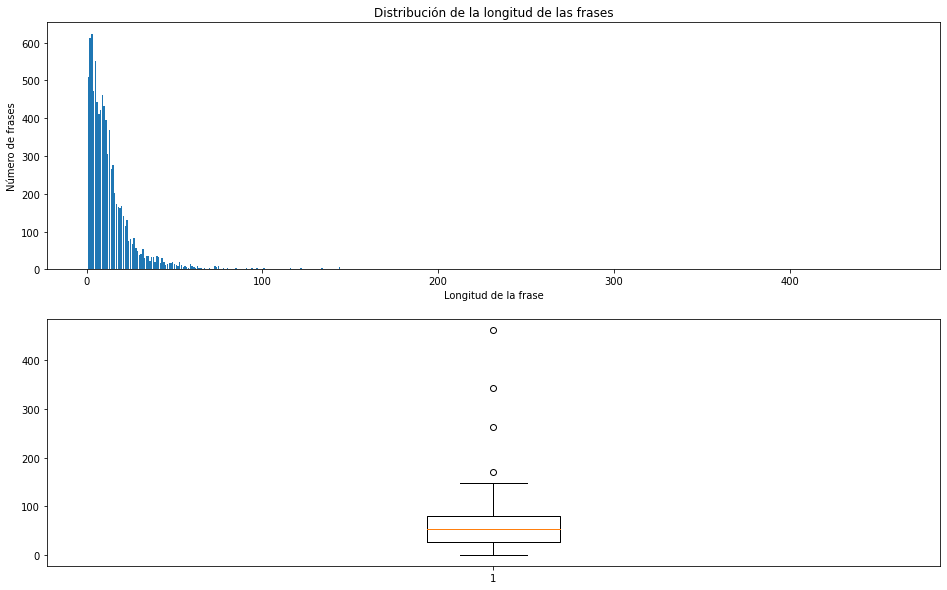

In [51]:
plot_text_length_distribution(dataset = training,
                              text_field = text_field)

**[EX 12]** 

Use the function *plot_text_length_distribution* to compare among all available text fields and describe what you appreciate.

**Solution**

In [52]:
print('We appreciate that most of the feedback comments have rather short lengths, with a mean nearby the 50 words. ')

We appreciate that most of the feedback comments have rather short lengths, with a mean nearby the 50 words. 


**[EX 13]** 

Define the *max_num_words* and explain why you have chose that number

**Solution**

In [53]:
max_num_words = 1000
print('We take one thousand as max num words since its about the 20% of our total vocabulary length.')

We take one thousand as max num words since its about the 20% of our total vocabulary length.


Once the vocabulary is defined, the next step is to convert the text into numerical values. To do this, we will use the already defined [*Tokenizer* function](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) and [*pad_sequences*](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) from Tensorflow - Keras

In [54]:
def map_text_into_numerical_values(dataset: pd.DataFrame,
                                   text_field: str,
                                   max_num_words: int,
                                   print_info: bool = True,
                                   tokenizer_dict = {}):
    # Tokenize the text
    if tokenizer_dict.get("tokenizer") is None:
        tokenizer = Tokenizer(num_words = max_num_words, split = " ")
        tokenizer.fit_on_texts(dataset[text_field].values)
        tokenizer_dict['tokenizer'] = tokenizer
    else:
        tokenizer = tokenizer_dict.get("tokenizer")
    tokens = tokenizer.texts_to_sequences(dataset[text_field].values)
    
    # Padd the values in order to get the same length
    padded_tokens = pad_sequences(tokens, maxlen = tokenizer_dict.get("max_pad_sequence_length"))
    if tokenizer_dict.get("max_pad_sequence_length") is None:
        tokenizer_dict["max_pad_sequence_length"] = len(padded_tokens[0])
        
    # Print some information
    if print_info:
        for index in range(0, 3):
            print("\n- Original token length: {} \n- Padded token length: {} \n- Text: {} \n- Tokenized text: {} \n- Padded tokenized text: {}".format(len(tokens[index]), 
                                                                                                                                                       len(padded_tokens[index]),
                                                                                                                                                       dataset[text_field].values[index], 
                                                                                                                                                       tokens[index],
                                                                                                                                                       padded_tokens[index]))

    return tokens, padded_tokens, tokenizer_dict

In [55]:
tokens, padded_tokens, tokenizer_dict = map_text_into_numerical_values(dataset = training,
                                                       text_field = text_field,
                                                       max_num_words = max_num_words)


- Original token length: 8 
- Padded token length: 356 
- Text: dont purchas becauseaft one month right side earphon work 
- Tokenized text: [26, 54, 9, 12, 103, 37, 8, 6] 
- Padded tokenized text: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

**[EX 14]**

Fill up the function *map_labels_to_onehot* (where is marked as TODO). This function will encode the labels into one-hot encoding values. 

Tip: see [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)

**Solution**

In [56]:
def map_labels_to_onehot(dataset: pd.DataFrame,
                         label_field: str):
    
    # TODO: return the labels encoded as one-hot
    return pd.get_dummies(dataset[label_field]).values


In [57]:
labels = map_labels_to_onehot(dataset = training,
                              label_field = "Sentiment")
labels

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

### 2.3. Getting training, validation and test datasets

At this point you have already defined the feature values (*padded_tokens*) and the target ones (*labels*), so the next step is to split them into training, validation and test datasets in order to be able to train and validate the model.

**[EX 15]**

Fill up the function *get_datasets* (where is marked as TODO). This function will return the training, validation and test datasets, all of them composed by features and labels.

**Solution**

In [58]:
def get_datasets(x, y, train_percentage = 0.9, validation_precentage = 0.5):
    #X_train, X_val, X_test, y_train, y_val, y_test = None, None, None, None, None, None
    
    # TODO: Get training dataset
    x_train, x_valtest, y_train, y_valtest = train_test_split(x, y, train_size = train_percentage, random_state=1)

    # TODO: Get test and validation datasets
    x_val, x_test, y_val, y_test = train_test_split(x_valtest, y_valtest, train_size = validation_precentage, random_state = 1)

    # Return
    return x_train, x_val, x_test, y_train, y_val, y_test


In [59]:
X_train, X_val, X_test, y_train, y_val, y_test = get_datasets(x = padded_tokens,
                                                              y = labels)

# 2.4. Build up the model

**[EX 16]**

Fill up the functions *build_model* and *train_model* to build and train up your own model (you can use whatever model you desire) and plot the main model metrics and defend, on the report, why you have chosen that model (from model selection to hyperparameters selection) based on graphics and metrics. 

**Solution**

In [60]:
import os
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.models import model_from_json
from keras.models import load_model
from tensorflow.keras import regularizers

def build_model(**params):
    # TODO: Build up the model  
    number_classes=labels.shape[1]

    model1 = Sequential()
    model1.add(keras.layers.Embedding(input_dim=max_num_words, output_dim = 128)) #The embedding layer
    model1.add(keras.layers.LSTM(32,dropout=0.5)) #Our LSTM layer
    model1.add(keras.layers.Dense(16,activation='relu'))
    model1.add(keras.layers.Dense(number_classes,activation='softmax'))


    model1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
    model1.summary()
    
    return model1
    

def train_model(model, **params):
    # TODO: train the model
    history = model.fit(X_train, y_train, epochs=epochs,validation_data=(X_test, y_test))

    return model, history

Build and train the model

In [61]:
# Build the model
model = build_model(max_num_words = max_num_words, labels=labels)

# Train the model
epochs=20
model, history = train_model(model = model, X_train=X_train, y_train=y_train, epochs = epochs)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         128000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                20608     
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 149,187
Trainable params: 149,187
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
254/254 [==============================] - 49s 191ms/step - loss: 0.9213 - accuracy: 0.5449 - val_loss: 0.7786 - val_accuracy: 0.6600
Epoch 2/20
254/254 [==============================] - 50s 198ms/step - loss: 0.6849 - accuracy: 0.7064 

In [62]:
score = model.evaluate(X_val, y_val)

15/15 [==============================] - 0s 30ms/step - loss: 0.6111 - accuracy: 0.8289


**[EX 17]**

Predict the sentiment over the test dataset

**Solution**

In [63]:
def get_prediction(model, 
                   data):
    # TODO: predict 
    predictions = model.predict(data).argmax(axis=1)
    return predictions

def map_prediction(prediction_array):
    # Define the sentiment dictionary
    sentiment_dictionary = {
        0: "bad", 
        1: "good",
        2: "neutral"
    }
    
    return list(map(sentiment_dictionary.get, prediction_array))

In [64]:
# Predict
predictions = get_prediction(model, data=X_test)

# And map to understandable format
map_prediction(predictions)[:10]

['neutral',
 'good',
 'neutral',
 'good',
 'bad',
 'good',
 'bad',
 'neutral',
 'good',
 'neutral']

**[EX 18]**

Fill up the function *do_text_transformations* in order to performs all text transformations seen above to a given text 

**Solution**

In [65]:
def do_text_transformations(data: pd.DataFrame,
                            text_field: str,
                            max_num_words: int,
                            tokenizer_dict: dict,
                            language: str = "english"):
    # TODO: Clean the text
    data['Text_Clean'] = data[text_field].apply(lambda text: clean_text(text))
    
    # TODO: Standardize the text
    data['Standardized_Text'] = data["Text_Clean"].apply(lambda text: standardize_text(text, language))
    
    # TODO: Map text to numerical values
    tokens, padded_tokens, tokenizer = map_text_into_numerical_values(dataset = data, text_field = text_field, max_num_words = max_num_words, tokenizer_dict=tokenizer_dict)
    
    # TODO: Assing the mapped text to dataset
    data['Padded_Text'] = padded_tokens.tolist()
    print(f'{type(data.Padded_Text)}')
    return data, padded_tokens

In [66]:
data_report, padded_tokens = do_text_transformations(data = data_report,
                                      text_field = "Text",
                                      tokenizer_dict = tokenizer_dict,
                                      max_num_words = max_num_words)


- Original token length: 6 
- Padded token length: 356 
- Text: If u are looking for decent thing under 2k go for them, but there is nill noise cancelation. Sometimes the noise is more than the person talking.
 
- Tokenized text: [67, 145, 129, 34, 558, 156] 
- Padded tokenized text: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

In [67]:
data_report

,Product,Price,Text,Star,id,Text_Clean,Standardized_Text,Padded_Text
1033,boAt Rockerz 255,1399,If u are looking for decent thing under 2k go ...,3,1033,if u are looking for decent thing under k go f...,u look decent thing k go nill nois cancel some...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
13493,JBL T110BT,2000,Good\n,4,13493,good,good,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8852,Sennheiser CX 6.0BT,6499,The sound is good. Ut there is a problem with ...,2,8852,the sound is good ut there is a problem with t...,sound good ut problem connector,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8125,Sennheiser CX 6.0BT,6499,"The sound is very good, though I am no pro wit...",4,8125,the sound is very good though i am no pro with...,sound good though pro sound like samsung soni ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
255,boAt Rockerz 255,1399,The product is good.Sound is almost acceptable...,4,255,the product is goodsound is almost acceptable ...,product goodsound almost accept pricegood bass...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...
92,boAt Rockerz 255,1399,"Amazon packaging : Not up to the mark, only co...",4,92,amazon packaging not up to the mark only comes...,amazon packag mark come plastic ploybag outer ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2055,boAt Rockerz 255,1399,"Good Battery, Sound. Cons- Bluetooth disconnec...",4,2055,good battery sound cons bluetooth disconnectin...,good batteri sound con bluetooth disconnect mo...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3045,boAt Rockerz 255,1399,Right side not working!!!!? 😖\n,1,3045,right side not working,right side work,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5251,Flybot Boom,1099,"Very happy to buy this product,Good quality , ...",5,5251,very happy to buy this productgood quality eve...,happi buy productgood qualiti everyth awesom t...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


**[EX 19]**

Fill up the function *predict_sentiment* in order to predict the sentiment for a given text

**Solution**

In [68]:
import torch
def predict_sentiment(model,
                      data: pd.DataFrame,
                      max_num_words: int,
                      tokenizer_dict: dict,
                      field_to_use: str):
    # TODO: Predict the sentiment for the given text
    #_, padded_tokens, _ = map_text_into_numerical_values(dataset = data, text_field = "Text", max_num_words = max_num_words, tokenizer_dict=tokenizer_dict)
    data['Sentiment_Prediction_Raw'] = get_prediction(model, padded_tokens)
    
    # TODO: Map the prediction
    data['Sentiment_Prediction'] = map_prediction(data["Sentiment_Prediction_Raw"])
    
    return data

In [69]:
data_report = predict_sentiment(model, data = data_report, tokenizer_dict = tokenizer_dict,
                                      max_num_words = max_num_words,field_to_use = "Padded_Text")

In [79]:
data_report.head(3)

,Product,Price,Text,Star,id,Text_Clean,Standardized_Text,Padded_Text,Sentiment_Prediction_Raw,Sentiment_Prediction
1033,boAt Rockerz 255,1399,If u are looking for decent thing under 2k go ...,3,1033,if u are looking for decent thing under k go f...,u look decent thing k go nill nois cancel some...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,neutral
13493,JBL T110BT,2000,Good\n,4,13493,good,good,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,good
8852,Sennheiser CX 6.0BT,6499,The sound is good. Ut there is a problem with ...,2,8852,the sound is good ut there is a problem with t...,sound good ut problem connector,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,good


**[EX 20]**

Fill up the functions *get_top_n_most_common_words*, *get_top_n_mainwords*, *get_main_and_related_words* that extracts a dataframe that indicates the main and related words per sentiment, and indicates which customer has used that words

**Solution**

In [71]:
def get_top_n_most_common_words(nltk_text: nltk.Text,
                                n: int):
    # TODO: Extract the top n most common words from a given text 
    dictionary = {}
    freq = nltk.FreqDist(samples = nltk_text.tokens)
    dictionary = {word: counter for word, counter in freq.most_common(n)}

       
    # Return
    return dictionary

def get_top_n_mainwords(data: pd.DataFrame,
                        text_field: str,
                        n: int):
    # Initialize the dataframes to be returned
    mainwords_count_df = pd.DataFrame(columns = ["MainWord", "MainWordCount"])
    mainwords_conversation_df = pd.DataFrame(columns=["MainWord", "Id"])    
    
    # TODO: Get the top n mainwords counts and review ids where the mainwords are presented
    nltk_text=data[text_field]
    most_common_words_dict =  get_top_n_most_common_words(nltk_text=convert_to_nltk_text(data, text_field), n=n)
    mainwords_count_df=mainwords_count_df.append(pd.DataFrame({"MainWord": most_common_words_dict.keys() ,
                                                               "MainWordCount": most_common_words_dict.values()}),
                                                 ignore_index = True, sort=False)
       


    print(f"Main words: {list(most_common_words_dict.keys())}")

    if most_common_words_dict:
          for mainword in most_common_words_dict.keys():
            aux_df = data[data[text_field].str.contains(mainword) == True]
            mainwords_conversation_df = mainwords_conversation_df.append(pd.DataFrame({"MainWord": mainword ,
                                                               "Id": aux_df["id"]}),
                                                             ignore_index=True, sort=False)
    
                
    return mainwords_count_df, mainwords_conversation_df



def get_main_and_related_words_per_sentiment(data: pd.DataFrame,
                                             n_mainwords: int,
                                             n_relatedwords: int,
                                             field_to_use: str,
                                             sentiment_field: str):
    # Initialize the dataframes to be returned
    mainwords_count_df = pd.DataFrame(columns = ["MainWord", "MainWordCount", "Sentiment"])
    mainwords_conversation_df = pd.DataFrame(columns=["MainWord", "Id", "Sentiment"])
    relatedword_per_mainword_df = pd.DataFrame(columns=["MainWord", "RelatedWord", "RelatedWordCount", "Sentiment"])

    # TODO: Get the mainwords and its related words per sentiment group.
    sentiment_groups=data.groupby(by=[sentiment_field], as_index=False)
    for group_date, grouped_df in sentiment_groups:
        sentiment=grouped_df[sentiment_field].values[0]
        print(f"Mainwords for sentiment: {sentiment}.") 
        mainwords_count_df_out, mainwords_conversation_df_out = get_top_n_mainwords(grouped_df, field_to_use, n_mainwords)

        for mainword in mainwords_count_df_out.MainWord.unique():
            aux_df=data[data[field_to_use].str.contains(mainword)==True]                                                                 
            if not aux_df.empty:
                most_common_words_dict = get_top_n_most_common_words(nltk_text=convert_to_nltk_text(aux_df, field_to_use), n=n_relatedwords)
              
                if most_common_words_dict:
                    relatedword_per_mainword_df_out = pd.DataFrame({"MainWord": mainword, "RelatedWord": most_common_words_dict.keys(), "RelatedWordCount": most_common_words_dict.values(), "Sentiment": sentiment})   
                    relatedword_per_mainword_df_out["Sentiment"]=sentiment       
                    relatedword_per_mainword_df = relatedword_per_mainword_df.append(relatedword_per_mainword_df_out)


        mainwords_count_df_out["Sentiment"]=sentiment
        mainwords_conversation_df_out["Sentiment"]=sentiment

        mainwords_count_df =mainwords_count_df.append(mainwords_count_df_out,ignore_index=True, sort=False)                                                                 
        mainwords_conversation_df = mainwords_conversation_df.append(mainwords_conversation_df_out, ignore_index=True, sort=False)  
     
        relatedword_per_mainword_df = relatedword_per_mainword_df[relatedword_per_mainword_df['MainWord'] != relatedword_per_mainword_df['RelatedWord']]                            

    return mainwords_count_df, mainwords_conversation_df, relatedword_per_mainword_df



In [72]:
mainwords_count_df, mainwords_conversation_df, relatedword_per_mainword_df = get_main_and_related_words_per_sentiment(data = data_report, 
                                                                                                                      n_mainwords = 10,
                                                                                                                      n_relatedwords = 10,
                                                                                                                      sentiment_field = "Sentiment_Prediction",
                                                                                                                      field_to_use = "Standardized_Text")

Mainwords for sentiment: bad.
Main words: ['product', 'sound', 'qualiti', 'work', 'bass', 'month', 'one', 'good', 'earphon', 'use']
Mainwords for sentiment: good.
Main words: ['good', 'sound', 'qualiti', 'product', 'bass', 'use', 'best', 'earphon', 'batteri', 'one']
Mainwords for sentiment: neutral.
Main words: ['good', 'sound', 'qualiti', 'product', 'bass', 'use', 'batteri', 'earphon', 'work', 'ear']


In [73]:
mainwords_count_df.head(3)

,MainWord,MainWordCount,Sentiment
0,product,107,bad
1,sound,94,bad
2,qualiti,90,bad


In [74]:
mainwords_conversation_df.head(3)

,MainWord,Id,Sentiment
0,product,4817,bad
1,product,1448,bad
2,product,5832,bad


In [75]:
relatedword_per_mainword_df.head(3)

,MainWord,RelatedWord,RelatedWordCount,Sentiment
1,product,good,210,bad
2,product,qualiti,173,bad
3,product,sound,170,bad


In [76]:
data_report.head(3)

,Product,Price,Text,Star,id,Text_Clean,Standardized_Text,Padded_Text,Sentiment_Prediction_Raw,Sentiment_Prediction
1033,boAt Rockerz 255,1399,If u are looking for decent thing under 2k go ...,3,1033,if u are looking for decent thing under k go f...,u look decent thing k go nill nois cancel some...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,neutral
13493,JBL T110BT,2000,Good\n,4,13493,good,good,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,good
8852,Sennheiser CX 6.0BT,6499,The sound is good. Ut there is a problem with ...,2,8852,the sound is good ut there is a problem with t...,sound good ut problem connector,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,good


**[EX 21]**

Save the *data_report*, *mainwords_count_df*, *mainwords_conversation_df*, *relatedword_per_mainword_df* and build up a dashboard with the idea of help to Customer Service to quickly understand what customers think about their product, identify those unsatisfied customers and see the main and related words

In [80]:
data_report.to_csv("outcomes/data_report.csv", sep=';')
mainwords_count_df.to_csv("outcomes/mainwords_count_df.csv", sep=';')
mainwords_conversation_df.to_csv("outcomes/mainwords_conversation_df.csv", sep=';')
relatedword_per_mainword_df.to_csv("outcomes/relatedword_per_mainword_df.csv", sep=';')